##### Copyright 2020 Google LLC.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import os
import numpy
import seaborn
import pandas
import matplotlib
import matplotlib.style
import matplotlib.patheffects
import matplotlib as mpl
from matplotlib import pyplot as pyplot
from scipy.spatial import distance

from IPython.display import display
from collections import OrderedDict

mpl.style.use('classic')

import random
import tempfile
import tarfile
import zipfile

# If required
!pip install python-Levenshtein

import Levenshtein
from Levenshtein import distance as ldistance

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp27-cp27mu-linux_x86_64.whl size=98777 sha256=4212c60530985927dc96fcc1c50cb4bf66a4ab61ee13d458631cf6f1b9dff1cc
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


## Load large dataframe of sequences

In [ ]:
# Version to use with Jupyter (put zip file in the same directory)
my_zip = zipfile.ZipFile('allseqs_20191230.csv.zip')
my_zip.extractall() # extract csv file to the current working directory

df = pandas.read_csv('allseqs_20191230.csv', index_col=None)
df.head(3)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True
2,ADEEIRTTNPVATEQWGGVSTNLQIGNY,designed,AD_____________W_G______I__Y,6,6,-0.527843,True


### Code used to create subsampled partitions

In [ ]:
sizes = df.groupby('partition').size().reset_index()
sizes[sizes.partition.str.endswith('walked')].sort_values(0)

,partition,0
8,lr_designed_plus_rand_train_walked,19680
10,lr_rand_doubles_plus_single_walked,19999
20,rnn_rand_doubles_plus_singles_walked,20154
5,cnn_standard_walked,20395
3,cnn_rand_doubles_plus_single_walked,20454
12,lr_standard_walked,20456
18,rnn_designed_plus_rand_train_walked,20731
1,cnn_designed_plus_rand_train_walked,20759
22,rnn_standard_walked,20838


In [ ]:
for p, g in df.groupby('partition'):
  if p not in ['lr_rand_doubles_plus_single_walked',
 'lr_designed_plus_rand_train_walked',
 'cnn_rand_doubles_plus_single_walked',
 'rnn_rand_doubles_plus_singles_walked',
 'cnn_standard_walked',
 'rnn_designed_plus_rand_train_walked',
 'rnn_standard_walked',
 'cnn_designed_plus_rand_train_walked',
 'lr_standard_walked',
 'designed']:
    continue
  subsample = g.sample(n=19680, replace=False, random_state=777)
  print p, subsample.shape
  subsample = subsample.sort_values(by='num_edits', ascending=False)  # sort far => near
  subsample.to_csv(index=None)

cnn_designed_plus_rand_train_walked (19680, 7)
cnn_rand_doubles_plus_single_walked (19680, 7)
cnn_standard_walked (19680, 7)
designed (19680, 7)
lr_designed_plus_rand_train_walked (19680, 7)
lr_rand_doubles_plus_single_walked (19680, 7)
lr_standard_walked (19680, 7)
rnn_designed_plus_rand_train_walked (19680, 7)
rnn_rand_doubles_plus_singles_walked (19680, 7)
rnn_standard_walked (19680, 7)


## Load subsampled partitions

In [ ]:
# Version to use with Jupyter (put tar file in the same directory)
my_tar = tarfile.open('subsampled.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

## Load clustered subsampled partitions

In [ ]:
# Version to use with Jupyter (put tar file in the same directory)
my_tar = tarfile.open('clusters.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

## Load viable clusters

In [ ]:
# Version to use with Jupyter (put tar file in the same directory)
my_tar = tarfile.open('viable_clusters.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

## Code used to make clusters from the sequence partitions

In [ ]:
def levenshtein_distances(df):
  """Calculates Levenshtein distance matrix for Wrangler df.

  Args:
    df: (dataframe) A frame representing experimental data from our
    collaborators containing a column 'sequence' with amino acid sequences.

  Returns:
    A numpy.ndarray(shape=(len(df), len(df)), dtype=float).
  """
  seqs = list(df.sequence)
  ldistance = Levenshtein.distance
  transformed_seqs = numpy.array(seqs).reshape(-1, 1)
  ld = distance.pdist(
      transformed_seqs, lambda x, y: ldistance(x[0], y[0]))
  return distance.squareform(ld)

In [ ]:
def get_clusters(df, dm, cluster_threshold):
  """Clusters sequences using a pairwise distance matrix at a threshold.

  Args:
    df: (dataframe) A pandas dataframe, containing a column 'sequence' with
      amino acid sequences, a column 'partition' indicating what dataset the
      sequences are from, and a column 'num_edits' indicating the Levenshtein
      distance of each amino acid sequence from the wildtype.
    dm: A numpy.ndarray(shape=(len(df), len(df)), dtype=float)
    cluster_threshold: Clustering radius to use.

  Returns:
    n_clusters: (int) Number of clusters formed.

    cluster_ids: (ndarray(int, shape=len(df)) Indicates which cluster each
      sequence has been assigned to (zero-indexed).
  """
  if len(df) != len(dm):
    raise ValueError(
        'Dataframe has %d sequences, but distance matrix is shape %r'
        % (len(df), dm.shape))

  cluster_ids = numpy.full(len(df), numpy.nan)
  is_unassigned = numpy.isnan(cluster_ids)
  current_cluster_id = 0
  while numpy.any(is_unassigned):
    # Next founder is lowest-index sequence that hasn't already been clustered.
    founder_index = numpy.where(is_unassigned)[0][0]
    cluster_mask = dm[:, founder_index] < cluster_threshold
    # Assign a cluster ID to the set of indices for the new cluster.
    cluster_ids[cluster_mask] = current_cluster_id

    is_unassigned = numpy.isnan(cluster_ids)
    current_cluster_id += 1

  return current_cluster_id, cluster_ids

In [ ]:
def get_all_clusters(df, dm=None, min_mut=0, min_cluster_threshold=5,
                     max_cluster_threshold=40):
  """Clusters a set of sequences using a range of cluster thresholds.

  The number of effective sequences is calculated at diversity thresholds in the
  range min_cluster_threshold to max_cluster_threshold specified.

  Args:
    df: (dataframe) A pandas dataframe, containing a column 'sequence' with
      amino acid sequences, a column 'partition' indicating what dataset the
      sequences are from, and a column 'num_edits' indicating the Levenshtein
      distance of each amino acid sequence from the wildtype with N sequences.
    dm: (numpy.array(shape=(N,N)) A pairwise distance matrix for the N sequences
      or None
    min_mut: (int) Cluster sequences greater than this distance from wild type.
    min_cluster_threshold: Smallest clustering radius to use.
    max_cluster_threshold: Largest clustering radius to use.

  Returns:
    n_clusters: (ndarray, size (nsteps-1)) Array containing the number of
      clusters found for each size between min_cluster_threshold and
      max_cluster_threshold inclusive.
    all_clusters_df: A pandas dataframe with the columns specified for the input
      df, plus an additional column per cluster threshold indicating the
      cluster_id of each sequence, with the column name denoting the cluster
      radius.
  """
  df = df[df.num_edits >= min_mut].copy()
  if dm is None:
    dm = levenshtein_distances(df)
  all_n_clusters = []
  for cluster_threshold in range(
      min_cluster_threshold, max_cluster_threshold+1):

    n_clusters, cluster_ids = get_clusters(df, dm, cluster_threshold)
    assert cluster_threshold not in df  # i.e., column doesnt exist already.
    df[cluster_threshold] = cluster_ids
    all_n_clusters.append(n_clusters)

  return all_n_clusters, df

### Example using the clustering code to cluster sequences from one partition.

In [ ]:
%%time
cluster_dir = 'clusters'
partition = 'designed'

f = os.path.join(cluster_dir, '%s.csv' % partition)
sequence_df = pandas.read_csv(f, index_col=None)

n_clusters, clustered_df = get_all_clusters(sequence_df, dm=None, min_mut=0, min_cluster_threshold=2, max_cluster_threshold=40)
clustered_df.head().T

CPU times: user 8min 8s, sys: 13.4 s, total: 8min 22s
Wall time: 8min 33s


### Example using the clustering code to cluster viable sequences from one partition.

In [ ]:
%%time
viable_cluster_dir = 'viable_clusters'
partition = 'designed'

f = os.path.join(viable_cluster_dir, '%s.csv' % partition)
df = pandas.read_csv(f, index_col=None)
 
viable_df = df[df.is_viable]

n_clusters, df_viable_clusters = get_all_clusters(viable_df, dm=None, min_cluster_threshold=2, max_cluster_threshold=40)
df_viable_clusters.head().T

CPU times: user 2min 56s, sys: 3.15 s, total: 2min 59s
Wall time: 3min 2s


## Num clusters vs radius plots (Figure 4a, viable sequence only)

In [ ]:
MIN_RADIUS = 2
MAX_RADIUS = 40
partitions = [
    'lr_rand_doubles_plus_single_walked',
    'lr_designed_plus_rand_train_walked',
    'cnn_rand_doubles_plus_single_walked',
    'rnn_rand_doubles_plus_singles_walked',
    'cnn_standard_walked',
    'rnn_designed_plus_rand_train_walked',
    'rnn_standard_walked',
    'cnn_designed_plus_rand_train_walked',
    'lr_standard_walked',
    'designed']
    

def load_clusterings(outdir, partition):
  f = os.path.join(outdir, '%s.csv' % partition)
  print('Loading data from "%s"' % partition)
  clusters_df = pandas.read_csv(f, index_col=None)
  return clusters_df


def get_all_cluster_stats(
    df, partition, min_radius=MIN_RADIUS, max_radius=MAX_RADIUS):
  all_stats = []
  for radius in range(min_radius, max_radius+1):
    stats = get_cluster_stats(df, radius)
    stats['radius'] = radius
    stats['partition'] = partition
    all_stats.append(stats)
  return pandas.concat(all_stats)


def get_cluster_stats(df, radius):
  cluster_id_colname = str(radius)
  stats = pandas.DataFrame([
    {
        'cluster_id': int(cluster_id),
        'num_seqs': len(cluster),
        'num_viable': cluster.is_viable.sum(),
        'precision': cluster.is_viable.mean(),    
    }
    for cluster_id, cluster 
    in df.groupby(by=cluster_id_colname)
  ])
  return stats

viable_clusterings = {
    p: load_clusterings('viable_clusters', p)
    for p in partitions
}

viable_clustering_stats = pandas.concat([
    get_all_cluster_stats(viable_clusterings[p], p)
    for p in partitions
])

print(viable_clustering_stats.shape)
viable_clustering_stats.head(5)

viable_clustering_stats_agg_rows = []
for (p, r), g in viable_clustering_stats.groupby(['partition', 'radius']):
  viable_clustering_stats_agg_rows.append(
      {'partition': p, 'radius': r, 'n_clusters': (g.num_viable > 0).sum()})
  
viable_clustering_stats_agg = pandas.DataFrame(viable_clustering_stats_agg_rows)  
display(viable_clustering_stats_agg.head())

Loading data from "lr_rand_doubles_plus_single_walked"
Loading data from "lr_designed_plus_rand_train_walked"
Loading data from "cnn_rand_doubles_plus_single_walked"
Loading data from "rnn_rand_doubles_plus_singles_walked"
Loading data from "cnn_standard_walked"
Loading data from "rnn_designed_plus_rand_train_walked"
Loading data from "rnn_standard_walked"
Loading data from "cnn_designed_plus_rand_train_walked"
Loading data from "lr_standard_walked"
Loading data from "designed"
(446879, 6)


,n_clusters,partition,radius
0,14183,cnn_designed_plus_rand_train_walked,2
1,13991,cnn_designed_plus_rand_train_walked,3
2,9272,cnn_designed_plus_rand_train_walked,4
3,6481,cnn_designed_plus_rand_train_walked,5
4,4662,cnn_designed_plus_rand_train_walked,6


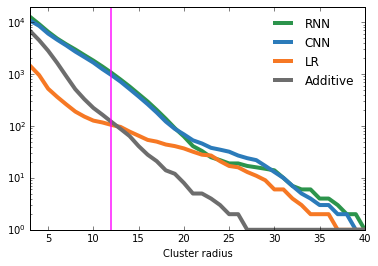

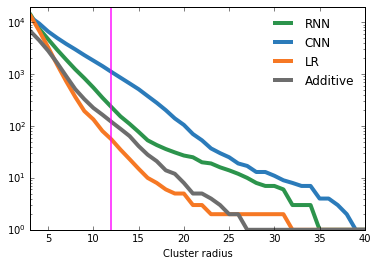

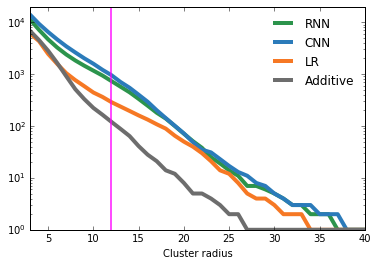

In [ ]:
legend_labels = {
    'cnn_designed_plus_rand_train_walked': 'CNN',
    'cnn_rand_doubles_plus_single_walked': 'CNN',
    'cnn_standard_walked': 'CNN',
    'designed': 'Additive',
    'lr_designed_plus_rand_train_walked': 'LR',
    'lr_rand_doubles_plus_single_walked': 'LR',
    'lr_standard_walked': 'LR',
    'rnn_designed_plus_rand_train_walked': 'RNN',
    'rnn_rand_doubles_plus_singles_walked': 'RNN',
    'rnn_standard_walked': 'RNN',    
}
blues_palette = seaborn.color_palette('Blues')
oranges_palette = seaborn.color_palette('Oranges')
purples_palette = seaborn.color_palette('Purples')
greens_palette = seaborn.color_palette('Greens')
DEFAULT_SATURATION_INDEX = -2
designed_color = (109/255., 109/255., 109/255.) # gray


def get_arch_color_for_partition(category, saturation_index=DEFAULT_SATURATION_INDEX):
  if category.startswith('lr'):
    color = oranges_palette[saturation_index-1]
  elif category.startswith('cnn'):
    color = blues_palette[saturation_index]
  elif category.startswith('rnn'):
    color = greens_palette[saturation_index]
  elif category == 'designed':
    color = designed_color
  elif category == 'rand':  # FIXME probably pick something better.... Sam used this for ivis plots so using for consistency
    color = 'black'
  else:
    raise ValueError('??: "%s"' % category)
  return color

  
def plot_num_clusters_vs_radius(
    df,
    partitions,
    figsize=(2.5, 1.5),
    dpi=300,
    scale=1,
    title=None):

  pyplot.figure()
  for partition in partitions:
    sub_df = df[df.partition == partition]
    label = legend_labels[partition]
    pyplot.plot(
        sub_df.radius, 
        sub_df.n_clusters, 
        color=get_arch_color_for_partition(partition),
        linestyle='-',
        linewidth=1*scale,
        label=label)
  pyplot.axvline(
      x=12, color='magenta', linestyle='-', alpha=.7, linewidth=.5*scale)
  pyplot.yscale('log')
  if title:
    pyplot.title(title, fontsize=24)
  
  xtick_values, _ = pyplot.xticks()
  pyplot.xticks([2] + list(xtick_values))
  pyplot.xlim(3, 40)
  pyplot.ylim(1, 20000)
  pyplot.legend(frameon=False)
  ax = pyplot.gca()
  ax.tick_params(axis='both')
  pyplot.xlabel('Cluster radius')

scale=4
plot_num_clusters_vs_radius(
    viable_clustering_stats_agg, 
    [
        'rnn_rand_doubles_plus_singles_walked',
        'cnn_rand_doubles_plus_single_walked',
        'lr_rand_doubles_plus_single_walked',     
        'designed',
    ],
    scale=scale)
plot_num_clusters_vs_radius(
    viable_clustering_stats_agg, 
    [
        'rnn_standard_walked',
        'cnn_standard_walked',
        'lr_standard_walked',                                             
        'designed',     
    ],
    scale=scale)
plot_num_clusters_vs_radius(
    viable_clustering_stats_agg, 
    [
        'rnn_designed_plus_rand_train_walked',
        'cnn_designed_plus_rand_train_walked',
        'lr_designed_plus_rand_train_walked',
        'designed',
    ],
    scale=scale)

## Figure 4b, Group by dataset line plots

In [ ]:
%%time
# takes ~7 mins
clusterings = {
    p: load_clusterings('clusters', p)
    for p in partitions
}

clustering_stats = pandas.concat([
    get_all_cluster_stats(clusterings[p], p)
    for p in partitions
])

print(clustering_stats.shape)
clustering_stats.head(5)

Loading data from "lr_rand_doubles_plus_single_walked"
Loading data from "lr_designed_plus_rand_train_walked"
Loading data from "cnn_rand_doubles_plus_single_walked"
Loading data from "rnn_rand_doubles_plus_singles_walked"
Loading data from "cnn_standard_walked"
Loading data from "rnn_designed_plus_rand_train_walked"
Loading data from "rnn_standard_walked"
Loading data from "cnn_designed_plus_rand_train_walked"
Loading data from "lr_standard_walked"
Loading data from "designed"
(830087, 6)
CPU times: user 8min 20s, sys: 3.13 s, total: 8min 23s
Wall time: 8min 27s


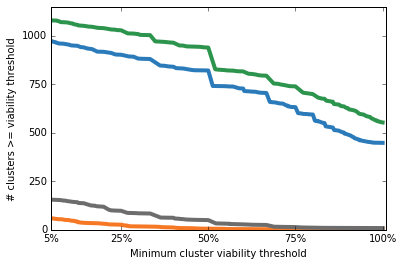

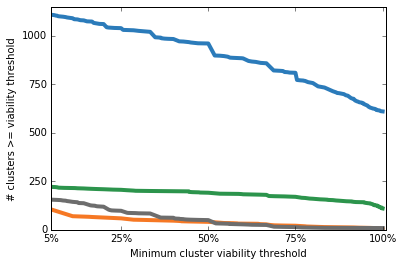

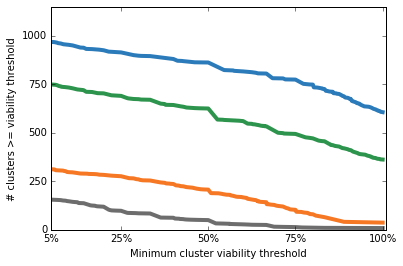

In [ ]:
def plot_n_clusters_vs_precision(
    cluster_stats, 
    partitions,
    dpi=300,
    figsize=(2.5, 1),
    radius=12,
    scale=1):

  pyplot.figure()
  data = {}
  cluster_stats = cluster_stats[cluster_stats.radius == radius]
  assert len(cluster_stats) > 0
  for partition in partitions:
    sub_df = cluster_stats[cluster_stats.partition == partition]
    if sub_df.empty:
      print('No rows for partition "%s"' % partition)
      continue
    precisions = sorted(sub_df.precision.unique())
    n_clusters_gt_p = [(sub_df.precision >= p).sum() for p in precisions]
    # print('line<%s>: %r' % (partition, zip(n_clusters_gt_p, precisions)))
    data[partition] = {'x': precisions, 'y': n_clusters_gt_p}
    pyplot.plot(
        precisions, n_clusters_gt_p, 
        label=legend_labels[partition],
        color=get_arch_color_for_partition(partition),
        linestyle='-',
        linewidth=1*scale,
        )
  xticks = numpy.linspace(0, 1, 5)
  xticks[0] = 0.05 # Move the start
  pyplot.xticks(xticks, ['%.0f%%' % (x*100) for x in xticks])
  pyplot.xlabel('Minimum cluster viability threshold')
  pyplot.ylabel('# clusters >= viability threshold')
  pyplot.xlim(xticks[0], xticks[-1] + 0.01)
  pyplot.ylim(0, 1150)
  pyplot.yticks([0, 250, 500, 750, 1000])
  ax = pyplot.gca()
  ax.tick_params(axis='both')


stats = clustering_stats
scale = 4
pdata = plot_n_clusters_vs_precision(stats, [
    'rnn_rand_doubles_plus_singles_walked',
    'cnn_rand_doubles_plus_single_walked',
    'lr_rand_doubles_plus_single_walked',
    'designed',
], scale=scale)
plot_n_clusters_vs_precision(stats, [
    'rnn_standard_walked',
    'cnn_standard_walked',
    'lr_standard_walked',                                             
    'designed',
], scale=scale)
plot_n_clusters_vs_precision(stats, [
    'rnn_designed_plus_rand_train_walked',
    'cnn_designed_plus_rand_train_walked',
    'lr_designed_plus_rand_train_walked',
    'designed',
], scale=scale)